# TP : Decision trees and ensemble methods

In the first part, you are asked to implement a **Stump**, i.e. a decision tree of depth 1, from scratch. Our tree should be able to handle weighted and unweighted samples, in order for it to be used as a weak learner for
**AdaBoost** in the second part.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_moons, make_circles, make_classification

The following code creates 3 synthetic datasets, in which there are just two features, for binary classification. We ask you to provide the solutions to the exercises on all elements of the list ```datasets```.

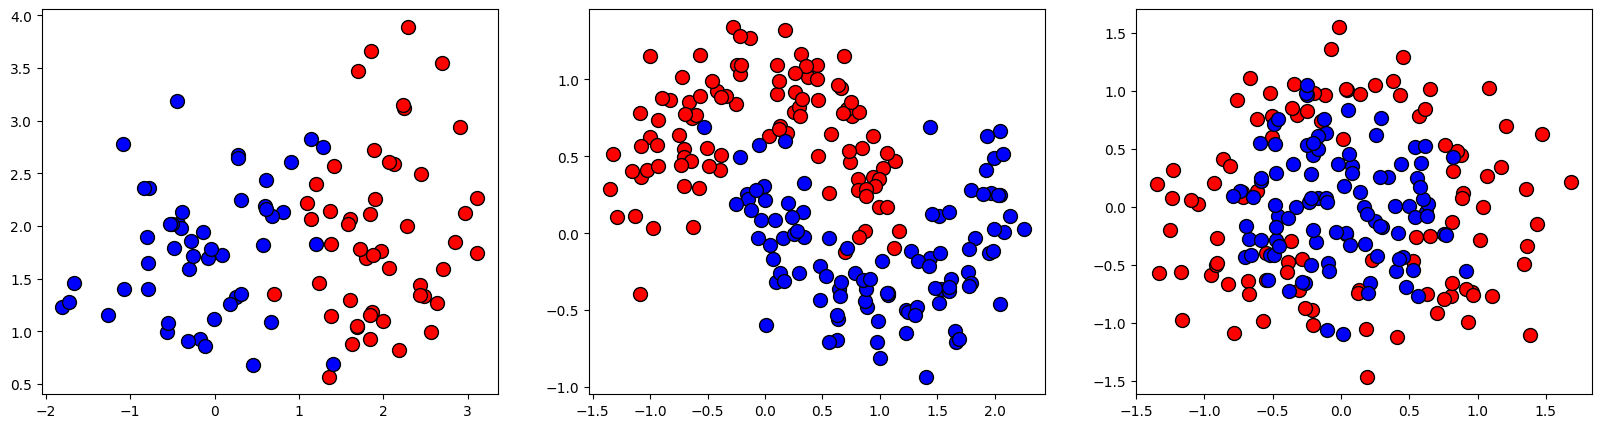

In [44]:
plot_colors = "rb"
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [linearly_separable,
            make_moons(n_samples = 200, noise=0.2, random_state=0),
            make_circles(n_samples = 200, noise=0.3, factor=0.5, random_state=1)
            ]

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]
    n_classes = len(np.unique(y))
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax[fi].scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.RdYlBu, edgecolor='black', s=100)
dataset = datasets[0]

In [3]:
def plot_tree(clf, X, y):
    n_classes = 2
    plot_colors = "rb"
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")
    # Plot the training points
    for i, color in zip([-1,1], plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)
    plt.show()

## First part: Stumps

In this first part, you will code your own class to handle stumps for 2-dimensional data and binary classification (i.e., the class takes value in $\{0, 1\}$). You can find the outline of the code you will need to write, following these instructions:
- Implement the ```fit``` method : since the weak learners are potentially executed a large number of times, efficiency is crucial. Use the incremental evaluation of the partitions seen in class : the complexity should be  $O(ndc)$ instead of the naive $O(n^2 dc)$ version. We assume that the sorting operations such as ```argsort``` are free because we only need to run them once. Iterate in the 2-dimensions for every possible split, evaluate the quality of each split using an incremental version of the Gini index (defined next) and store the best split. (Note : a non-incremental version will be graded with half the points)
- Implement the ```gini``` method : Implement the Gini index coefficient for the case in which there are only 2 classes. In class, you saw the unweighted case: we quickly recall the unweighted then weighted version. Let $C$ be the number of different classes, $p_k(S)$ be the ratio of datapoints of class $k$ in region $S$. Then, the Gini index $G(S)$ is $$ G(S) = 1 - \sum_{k=1}^{C} p_k(S)^2$$ Given a split in which we have left and right regions $S_r$, $S_l$, let $N_r$ (resp. $N_l$) be the number of datapoints in $S_r$ (resp. $S_l$). The Gini index of the split is the combination of the Gini index of both regions: $$ \frac{N_r}{N_r + N_l}G(S_r) + \frac{N_l}{N_r + N_l}G(S_l) $$ For generalizing to the weighted case, let $w_k(S)$ be the sum of the weights of all data-points of class $k$ in $S$. The Gini index is defined as follows: $$ G(S) = 1 - \sum_{k=1}^{C} \left( \frac{w_k(S)}{  \sum_{m=1}^{C} w_m(S)} \right)^2 $$ Given a split in which we have left and right regions $S_r$, $S_l$, let $W_r = \sum_{k=1}^{C} w_k(S)$ (resp. $W_l$) the total weight on $S_r$ (resp. $S_l$). The Gini index of the partition is the combination of the Gini index of both regions: $$ \frac{W_r}{W_r + W_l}G(S_r) + \frac{W_l}{W_r + W_l}G(S_l) $$
- Implement the ```predict``` method. The input is an array of $n$ $d$-dimensional observations. The output is a ```np.array``` of length $n$. Once the ```predict``` method is coded, use the given function ```plot_tree(my_stump, X, y)``` to plot ```my_stump``` on each of the ```datasets```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [126]:
from sklearn import tree

class My_stump:
    def __init__(self):
        self.best_dimension = None
        self.best_threshold = None
        self.class_bellow_threshold = None
        self.class_above_threshold = None
        self.best_ev = None
        
    def get_threshold(self): return self.best_threshold
  
    def get_best(self): return self.best_dimension,  self.best_threshold, self.best_ev
    
    def gini_impurity(self, r0, l0, r1, l1):

        weightTot = r0 + r1 + l0 + l1

        giniLeft = 1 - (l1/(l1+l0))**2 - (l0/(l0+l1))**2
        giniRight = 1 - (r0/(r0+r1))**2 - (r1/(r0+r1))**2

        gini = ((l0 + l1)/weightTot) * giniLeft + ((r0 + r1)/weightTot) * giniRight

        return gini
    
    def fit(self, X, y, sample_weight=None):
        y = (y == 1)
        score = []
        bestThresholds = []
        
        for d in range(X.shape[1]):
            mask = np.argsort(X[:,d])
            ySort = y[mask]
            sample_weightSort = sample_weight[mask]
            score_d = 1 
            Xsort = X[mask, d]
            thresholds = (Xsort[:-1] + Xsort[1:])/2
            
            l0,l1 = 0,0
            r0, r1 = sample_weight[y==0].sum(), sample_weight[y==1].sum()
            k = 0
            
            for t in thresholds:
                if ySort[k]==1:
                    l1 += sample_weightSort[k]
                    r1 -= sample_weightSort[k]
                else: 
                    l0 += sample_weightSort[k]
                    r0 -= sample_weightSort[k]
                k += 1

                score_test = self.gini_impurity(r0, l0, r1, l1)
                if score_test < score_d:
                    score_d = score_test
                    threshold_d = t
            
            score.append(score_d)
            bestThresholds.append(threshold_d)

        self.best_dimension = np.asarray(score).argmin()
        self.best_threshold = bestThresholds[self.best_dimension] 

        yLeft = y[X[:, self.best_dimension] < self.best_threshold]
        yRight = y[X[:, self.best_dimension] > self.best_threshold]

        nl1, nr1 = yLeft.sum(), yRight.sum()
        nl0, nr0 = (1-yLeft).sum(), (1-yRight).sum()
        pl1 = nl1/(nl1+nl0), nl0/(nl1+nl0)
        pr1= nr1/(nr1+nr0), nr0/(nr1+nr0)

        if pl1 > pr1:
            self.class_bellow_threshold = 1
            self.class_above_threshold = -1
        else:
            self.class_bellow_threshold = -1
            self.class_above_threshold = 1

    
    def predict(self, X) :
        res = np.zeros(X.shape[0])
        
        res[X[:, self.best_dimension] < self.best_threshold] = self.class_bellow_threshold
        res[X[:, self.best_dimension] > self.best_threshold] = self.class_above_threshold


        return res  

- Using ```DecisionTreeClassifier``` in ```sklearn```, fit a stump on the data.

In [134]:
dataset = datasets[2]
X = dataset[0]
y = dataset[1]*2-1 
w = np.ones(len(X))

my_stump = My_stump()
my_stump.fit(X, y, w)
my_stump.predict(X)

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,  1

- Check the correctness of your code: With ```tree.plot_tree(sk_stump)``` compare the dimension of the split, the threshold and the Gini indices obtained through your own code and those of ```sk_stump```.

Difference in the best threshold: -1.7781981442865913e-08


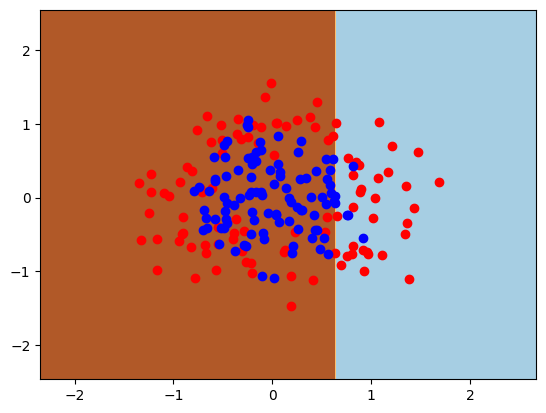

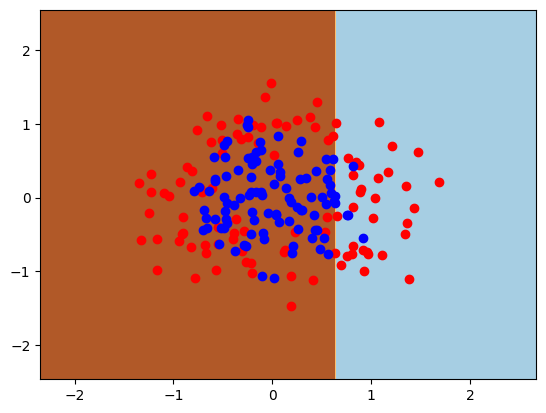

In [135]:
# Check your code
sk_stump = tree.DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w)
my_stump = My_stump()
my_stump.fit(X, y, w)

print("Difference in the best threshold:", sk_stump.tree_.threshold[0] -  my_stump.get_threshold())

plot_tree(my_stump,X,y)
plot_tree(sk_stump,X,y)

## Second part: Adaboost

Implement the **AdaBoost** seen in class. You can use the ```my_stump``` implemented before. We encourage you to check the correctness by comparing it to ```sk_stump```.
- Implement the ```fit``` function in the provided template using the utility functions.

<div class='alert alert-block alert-info'>
            Code:</div>

In [138]:
import pandas as pd

# Compute the error rate of a weak classifier with weights w_m
def compute_error(y, y_pred, w_m):

    return w_m[y != y_pred].sum()

# Compute alpha 
def compute_alpha(error):
    return 0.5 *  np.log((1-error) / error)

# Compute the update of the weights
def update_weights(w_i, alpha, y, y_pred, error):
    return (w_i * np.exp(-alpha*y_pred*y)) / (2*np.sqrt(error*(1-error)))


class AdaBoost:
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.loss_ensemble = []
        
    def predict(self, X):
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 
        for m in range(len(self.G_M)):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred.values

    def fit(self, X, y, M = 10):
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        Z=1        
        for m in range(0, M):# Iterate over M weak classifiers
            if m == 0:
                w_m = np.ones(len(y)) * 1 / len(y)  
            else:
                w_m = update_weights(w_m, alpha_m, y, y_pred, error_m)
            sk_stump = tree.DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w)
            sk_stump.fit(X, y, w_m)
            y_pred = sk_stump.predict(X)
            error_m = compute_error(y, y_pred, w_m)
            alpha_m = compute_alpha(error_m)

            self.G_M.append(sk_stump) # Save to list of weak classifiers
            self.alphas.append(alpha_m)
            Z = Z * (2 * np.sqrt(error_m * (1 - error_m)))
            self.loss_ensemble.append(Z) 
        

- Run the code for 20 iterations. At each iteration, plot the result of the ensemble of AdaBoost ```ab``` using ```plot_tree(ab, X, y)```
- Plot the evolution of the loss in the 20 iterations.

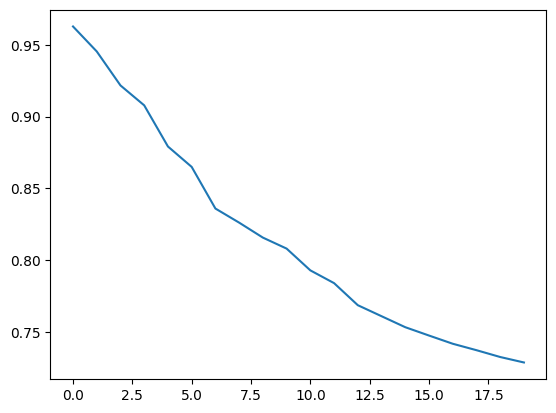

C:\Users\anais\AppData\Local\Temp\ipykernel_9060\637391896.py:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weak_preds.iloc[:,m] = y_pred_m
C:\Users\anais\AppData\Local\Temp\ipykernel_9060\637391896.py:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weak_preds.iloc[:,m] = y_pred_m
C:\Users\anais\AppData\Local\Temp\ipykernel_9060\637391896.py:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.c

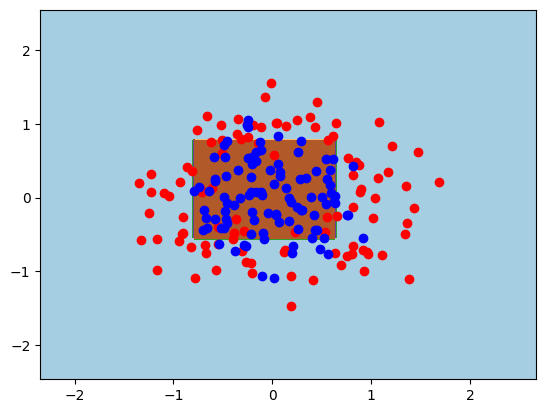

In [139]:
from sklearn.tree import DecisionTreeClassifier

ab = AdaBoost()
ab.fit(X, y, M = 20)
plt.plot(ab.loss_ensemble)
plt.show()
plot_tree(ab, X, y)